<a href="https://colab.research.google.com/github/apchavezr/19.-Procesamiento-del-Lenguaje-Natural/blob/main/TTR_Sentimiento_PQRD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolución de TTR y polaridad de sentimiento en PQRD

Este cuaderno reproduce el ejemplo didáctico con datos simulados de Bogotá.

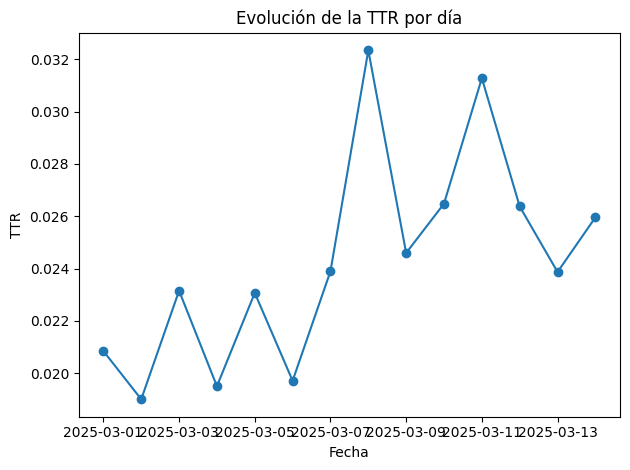

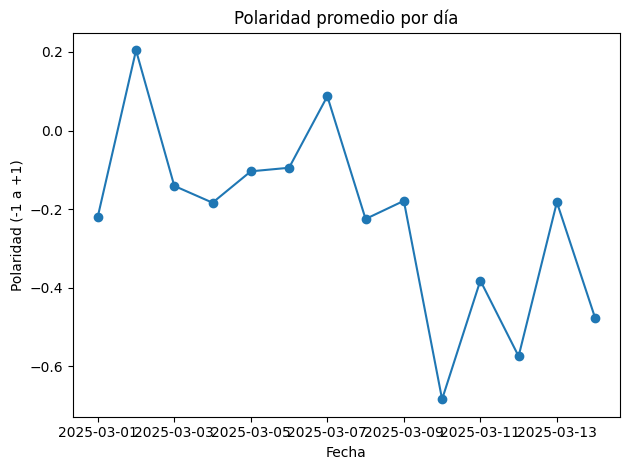

In [1]:

import random, re, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
BASE = Path("."); BASE.mkdir(exist_ok=True)
np.random.seed(7); random.seed(7)
dias = pd.date_range("2025-03-01", periods=14, freq="D")
lex_base = ["facturación","factura","cobro","adicional","error","servicio","agua","pedido","pago","ajuste","claridad","revisión","trámite","soporte"]
plantillas_base = ["Solicitud por {w1} en {w2} del {w3}.","Reporte de {w1} con {w2}.","Error en {w1} requiere {w2}.","Inconformidad por {w1} y {w2}."]
lex_emergente = ["corte","agua","Suba","emergencia","sin","suministro","reparación","acueducto","avería","sector","afectación","urgente"]
plantillas_emergentes = ["Se reporta {w1} de {w2} en {w3}.","Ciudadanía informa {w1} {w2} en {w3}.","Sin {w2} en {w3}, solicitud de {w1}."]
def gen(tema="base"):
    import random
    if tema=="base":
        return random.choice(plantillas_base).format(w1=random.choice(lex_base),w2=random.choice(lex_base),w3=random.choice(["mes","servicio","contrato"]))
    else:
        return random.choice(plantillas_emergentes).format(w1=random.choice(["corte","falla","avería","reparación"]),w2=random.choice(["agua","suministro"]),w3=random.choice(["Suba","Suba","Suba","Engativá"]))
np_msgs = np.random.randint(180,260,size=len(dias))
rows = []
for i,d in enumerate(dias):
    mezcla = 0.0 if i<7 else (0.2 if i==7 else (0.5 if i==8 else 0.8))
    for _ in range(np_msgs[i]):
        tema = "emergente" if (i>=7 and random.random()<mezcla) else "base"
        rows.append({"fecha": d.date().isoformat(), "texto": gen(tema)})
df = pd.DataFrame(rows)
pat = re.compile(r"[A-Za-zÁÉÍÓÚÜÑáéíóúüñ]+", re.UNICODE)
def toks(t): return pat.findall(t)
ttr_rows = []
for fecha, g in df.groupby("fecha"):
    seq = []; [seq.extend(toks(t)) for t in g["texto"]]
    n_tok = len(seq); n_typ = len({w.lower() for w in seq})
    ttr_rows.append({"fecha": fecha, "ttr": (n_typ/n_tok if n_tok else 0.0)})
df_ttr = pd.DataFrame(ttr_rows).sort_values("fecha")
pol_rows = []
for i,(fecha, g) in enumerate(df.groupby("fecha")):
    if i<=6: mu,sigma = -0.1,0.25
    elif 7<=i<=8: mu,sigma = -0.2,0.3
    elif 9<=i<=11: mu,sigma = -0.6,0.25
    else: mu,sigma = -0.2,0.25
    pol = float(np.clip(np.random.normal(mu,sigma,1)[0], -1.0, 1.0))
    pol_rows.append({"fecha": fecha, "polaridad_prom": pol})
df_sent = pd.DataFrame(pol_rows)
# Gráficas
plt.figure(); plt.plot(pd.to_datetime(df_ttr["fecha"]), df_ttr["ttr"], marker="o"); plt.title("Evolución de la TTR por día"); plt.xlabel("Fecha"); plt.ylabel("TTR"); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(pd.to_datetime(df_sent["fecha"]), df_sent["polaridad_prom"], marker="o"); plt.title("Polaridad promedio por día"); plt.xlabel("Fecha"); plt.ylabel("Polaridad (-1 a +1)"); plt.tight_layout(); plt.show()
